<a href="https://colab.research.google.com/github/nhantran2112/BlackHole/blob/main/SAiB_Amazon_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D

import seaborn as sns

In [27]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

In [55]:
data = pd.read_csv("dataset/amazon_reviews.csv", engine='python')

## **Tiền xử lý dữ liệu**

In [56]:
data

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,4910,"ZM ""J""",1.0,I bought this Sandisk 16GB Class 10 to use wit...,2013-07-23,503,0,0,0,0,0.0,0.0
4911,4911,Zo,5.0,Used this for extending the capabilities of my...,2013-08-22,473,0,0,0,0,0.0,0.0
4912,4912,Z S Liske,5.0,Great card that is very fast and reliable. It ...,2014-03-31,252,0,0,0,0,0.0,0.0
4913,4913,Z Taylor,5.0,Good amount of space for the stuff I want to d...,2013-09-16,448,0,0,0,0,0.0,0.0


In [58]:
data.isnull().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [59]:
data.dropna(inplace=True)

In [60]:
data.duplicated().sum()

0

In [61]:
#Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation and special characters
    return text

data['cleaned_text'] = data['reviewText'].apply(clean_text)
#Tokenization
data['tokenized_text'] = data['cleaned_text'].apply(word_tokenize)
#Remove Stopwords
stop_words = set(stopwords.words('english'))
data['filtered_text'] = data['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])
#Lemmatization or Stemming
lemmatizer = WordNetLemmatizer()
data['lemmatized_text'] = data['filtered_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data.drop(['helpful_yes','helpful_no','total_vote','score_pos_neg_diff','score_average_rating','wilson_lower_bound','cleaned_text','tokenized_text','filtered_text'], axis=1, inplace=True)
data

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,lemmatized_text
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,"[purchased, device, worked, advertised, never,..."
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,"[work, expected, sprung, higher, capacity, thi..."
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,"[think, worked, greathad, diff, bran, 64gb, ca..."
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,"[bought, retail, packaging, arrived, legit, or..."
5,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,"[mini, storage, doesnt, anything, else, suppos..."
...,...,...,...,...,...,...,...
4910,4910,"ZM ""J""",1.0,I bought this Sandisk 16GB Class 10 to use wit...,2013-07-23,503,"[bought, sandisk, 16gb, class, 10, use, htc, i..."
4911,4911,Zo,5.0,Used this for extending the capabilities of my...,2013-08-22,473,"[used, extending, capability, samsung, galaxy,..."
4912,4912,Z S Liske,5.0,Great card that is very fast and reliable. It ...,2014-03-31,252,"[great, card, fast, reliable, come, optional, ..."
4913,4913,Z Taylor,5.0,Good amount of space for the stuff I want to d...,2013-09-16,448,"[good, amount, space, stuff, want, fit, gopro,..."


In [ ]:
data.to_csv('dataset/amazon_reviews_preprocessing_data.csv', index=False)

# **Phân tích tập trung vào từ vựng (Lexical Analysis)**

In [62]:
# Instantiate the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Add a new column with sentiment scores based on lemmatized text
data['sentiment_score'] = data['lemmatized_text'].apply(lambda x: sid.polarity_scores(' '.join(x))['compound'])

# Classify sentiment based on the compound score
data['sentiment'] = data['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

In [67]:
data['sentiment'].value_counts()

positive    3909
negative     628
neutral      376
Name: sentiment, dtype: int64

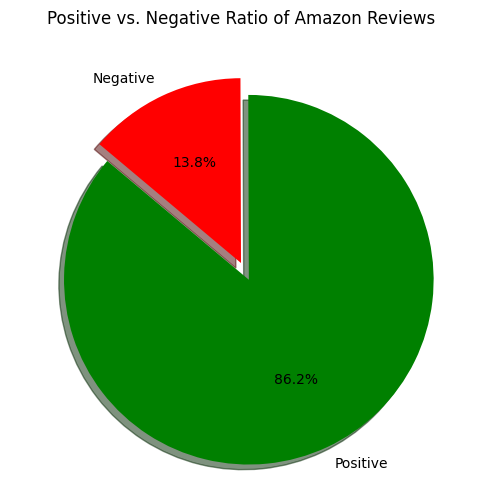

In [69]:
positive_reviews = data[data['sentiment'] == 'positive']
negative_reviews = data[data['sentiment'] == 'negative']

positive_ratio = len(positive_reviews) / len(data)
negative_ratio = len(negative_reviews) / len(data)

# Positive vs. Negative Pie Chart
plt.figure(figsize=(6, 6))
labels = ['Positive', 'Negative']
sizes = [positive_ratio, negative_ratio]
colors = ['green', 'red']
explode = (0.1, 0)  # explode the 1st slice (i.e., 'Positive')

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Positive vs. Negative Ratio of Amazon Reviews')
plt.show()

# **Phân tích ngữ cảnh (Contextual Analysis)**

In [66]:
data['reviewTime'] = pd.to_datetime(data['reviewTime'])

In [68]:
# Phân tích ngữ cảnh và ngữ cảnh liên quan đến sản phẩm và thời gian
def analyze_review(row):
    review_text = row['reviewText']
    product_keywords = ['device', 'phone', 'memory', 'download', 'stuff']  # Thêm từ khóa sản phẩm cần theo dõi

    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(review_text)

    # Phân tích ngữ cảnh
    if sentiment_scores['compound'] >= 0.05:
        sentiment = 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    # Phân tích ngữ cảnh liên quan đến sản phẩm
    product_related_sentiment = 'Neutral'
    for keyword in product_keywords:
        if keyword in review_text:
            product_related_sentiment = sentiment
            break

    # Phân tích ngữ cảnh liên quan đến thời gian
    if row['day_diff'] <= 30:  # Ví dụ: xem xét gần đây trong vòng 30 ngày
        time_related_sentiment = sentiment
    else:
        time_related_sentiment = 'Neutral'

    return pd.Series({'SentimentContextual': sentiment, 'ProductRelatedSentiment': product_related_sentiment, 'TimeRelatedSentiment': time_related_sentiment})

# Áp dụng hàm phân tích cho mỗi hàng trong DataFrame
data[['SentimentContextual', 'ProductRelatedSentiment', 'TimeRelatedSentiment']] = data.apply(analyze_review, axis=1)

# In kết quả
data['SentimentContextual'].value_counts()

                                             reviewText SentimentContextual  \
1     Purchased this for my device, it worked as adv...            Negative   
2     it works as expected. I should have sprung for...            Negative   
3     This think has worked out great.Had a diff. br...            Positive   
4     Bought it with Retail Packaging, arrived legit...            Positive   
5     It's mini storage.  It doesn't do anything els...             Neutral   
...                                                 ...                 ...   
4910  I bought this Sandisk 16GB Class 10 to use wit...             Neutral   
4911  Used this for extending the capabilities of my...            Positive   
4912  Great card that is very fast and reliable. It ...            Positive   
4913  Good amount of space for the stuff I want to d...            Positive   
4914  I've heard bad things about this 64gb Micro SD...            Positive   

     ProductRelatedSentiment TimeRelatedSentiment  

Positive    3707
Negative     842
Neutral      364
Name: SentimentContextual, dtype: int64

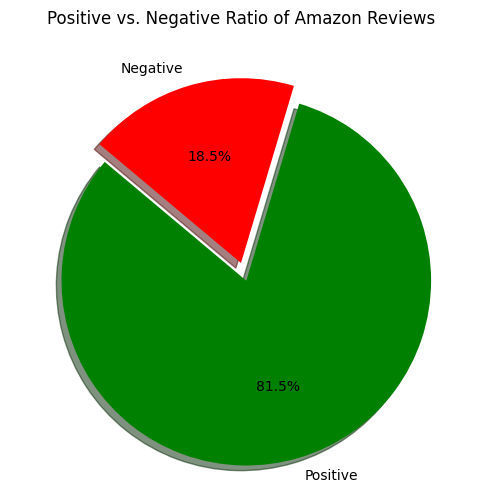

In [70]:
positive_reviews = data[data['SentimentContextual'] == 'Positive']
negative_reviews = data[data['SentimentContextual'] == 'Negative']

positive_ratio = len(positive_reviews) / len(data)
negative_ratio = len(negative_reviews) / len(data)

# Positive vs. Negative Pie Chart
plt.figure(figsize=(6, 6))
labels = ['Positive', 'Negative']
sizes = [positive_ratio, negative_ratio]
colors = ['green', 'red']
explode = (0.1, 0)  # explode the 1st slice (i.e., 'Positive')

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Positive vs. Negative Ratio of Amazon Reviews')
plt.show()

# **Phân tích tâm trạng theo thời gian (Temporal Sentiment Analysis)**

<ipython-input-72-f57c2980e501>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=data['reviewTime'], y=data['sentiment_score'], ci=None)


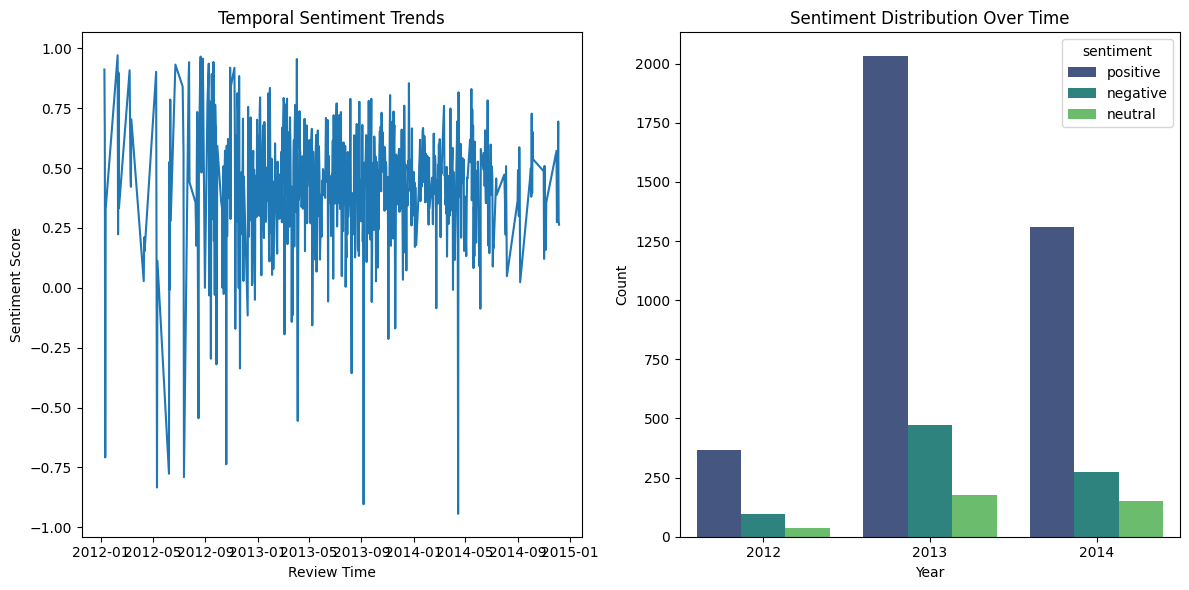

In [72]:
# Sort DataFrame by 'reviewTime'
data = data.sort_values(by='reviewTime')

# Perform sentiment analysis on reviews
data['sentiment_score'] = data['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])
data['sentiment'] = data['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

# Plot temporal sentiment trends
plt.figure(figsize=(12, 6))

# Line plot for sentiment trends
plt.subplot(1, 2, 1)
sns.lineplot(x=data['reviewTime'], y=data['sentiment_score'], ci=None)
plt.title('Temporal Sentiment Trends')
plt.xlabel('Review Time')
plt.ylabel('Sentiment Score')

# Bar plot for sentiment distribution over time
plt.subplot(1, 2, 2)
sns.countplot(x=data['reviewTime'].dt.year, hue=data['sentiment'], palette='viridis')
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# **Phân tích về khía cạnh cụ thể**

<ipython-input-73-6587a6ba7ed8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aspect_reviews['sentiment'] = aspect_sentiments.apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))


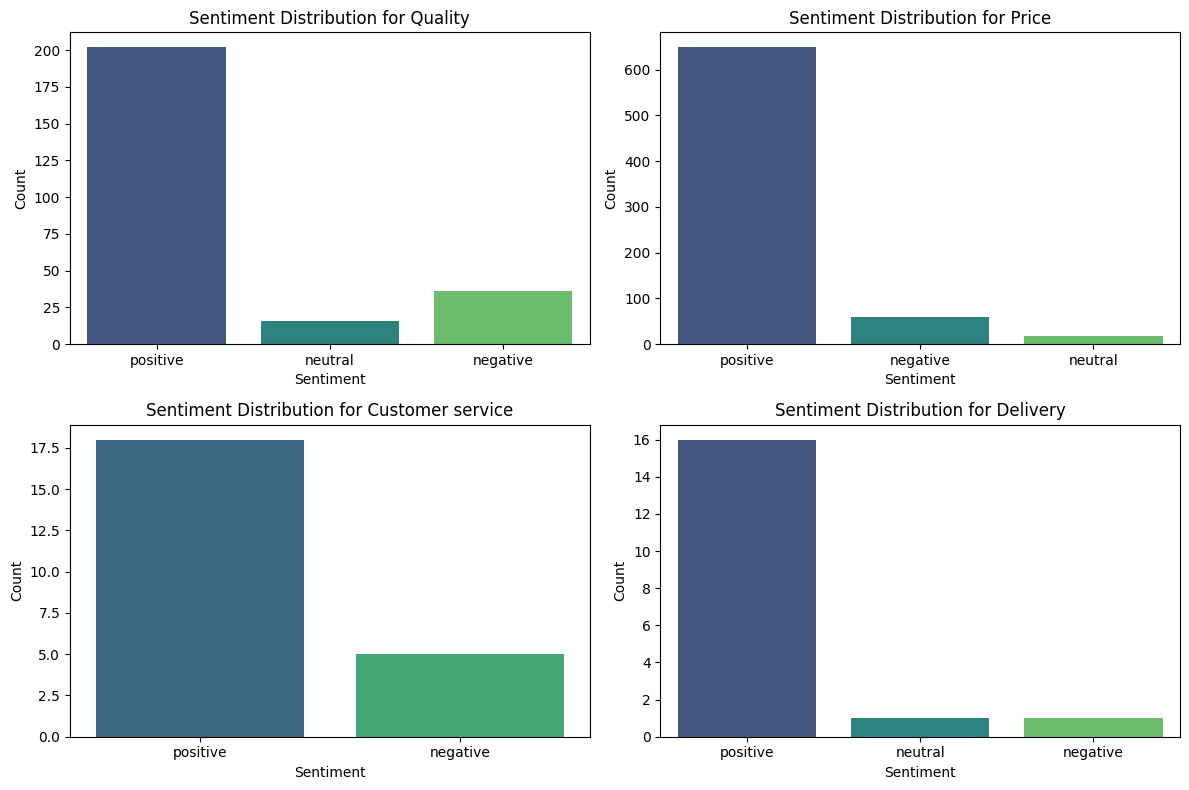

In [73]:

aspects_of_interest = ['quality', 'price', 'customer service', 'delivery']

# Function to identify aspects in text
def identify_aspect(text):
    text = text.lower()
    for aspect in aspects_of_interest:
        if re.search(fr'\b{aspect}\b', text):
            return aspect
    return None

# Apply the function to create a new column for identified aspects
data['identified_aspect'] = data['reviewText'].apply(identify_aspect)

# Filter out rows where an aspect was identified
aspect_reviews = data[~data['identified_aspect'].isnull()]

# Perform sentiment analysis on aspect reviews
aspect_sentiments = aspect_reviews['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])
aspect_reviews['sentiment'] = aspect_sentiments.apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

# Visualize sentiments for each aspect
plt.figure(figsize=(12, 8))

for aspect in aspects_of_interest:
    subset = aspect_reviews[aspect_reviews['identified_aspect'] == aspect]
    plt.subplot(2, 2, aspects_of_interest.index(aspect) + 1)
    sns.countplot(x=subset['sentiment'], palette='viridis')
    plt.title(f'Sentiment Distribution for {aspect.capitalize()}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# **Phân loại tâm trạng (Sentiment Classification) Naive Bayes**

In [23]:
# Chuẩn bị dữ liệu
texts = data['lemmatized_text'].astype(str).tolist()
overall_labels = data['overall'].astype(int).tolist()

# Chuyển đổi nhãn thành dạng số
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(overall_labels)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

In [24]:
# Tokenize văn bản
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

MultinomialNB()

In [25]:
# Đưa ra dự đoán trên tập kiểm tra
predictions = classifier.predict(X_test_vectorized)

# Đánh giá hiệu suất
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Đánh giá mô hình
print(classification_report(y_test, predictions))

Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.77      0.37      0.50        54
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        25
           3       0.29      0.02      0.03       110
           4       0.81      0.99      0.89       780

    accuracy                           0.81       983
   macro avg       0.37      0.28      0.29       983
weighted avg       0.72      0.81      0.74       983



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Phân tích cảm xúc sâu (Deep Emotion Analysis) RNN**

In [21]:
# Kiểm tra số lượng lớp trong tập huấn luyện
unique_labels_train = np.unique(y_train)
print("Số lượng lớp trong tập huấn luyện:", len(unique_labels_train))

# Kiểm tra số lượng lớp trong tập kiểm tra
unique_labels_test = np.unique(y_test)
print("Số lượng lớp trong tập kiểm tra:", len(unique_labels_test))

# Tokenize văn bản và chuyển đổi thành dạng số
max_words = 1000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(sequences_train, maxlen=max_len)
X_test_pad = pad_sequences(sequences_test, maxlen=max_len)

# Xây dựng mô hình RNN
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=32, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(len(unique_labels_train), activation='softmax'))  # Sử dụng softmax vì là bài toán multiclass classification

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Dự đoán cảm xúc cho dữ liệu mới
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)

# In báo cáo phân loại
print(classification_report(y_test, predicted_labels))

Số lượng lớp trong tập huấn luyện: 5
Số lượng lớp trong tập kiểm tra: 5
Epoch 1/10
62/62 [==============================] - 17s 202ms/step - loss: 0.8419 - accuracy: 0.7878 - val_loss: 0.7172 - val_accuracy: 0.7935
Epoch 2/10
62/62 [==============================] - 8s 128ms/step - loss: 0.6584 - accuracy: 0.8028 - val_loss: 0.6655 - val_accuracy: 0.7976
Epoch 3/10
62/62 [==============================] - 12s 190ms/step - loss: 0.5714 - accuracy: 0.8178 - val_loss: 0.6448 - val_accuracy: 0.8087
Epoch 4/10
62/62 [==============================] - 8s 125ms/step - loss: 0.5354 - accuracy: 0.8270 - val_loss: 0.6282 - val_accuracy: 0.8118
Epoch 5/10
62/62 [==============================] - 12s 192ms/step - loss: 0.5115 - accuracy: 0.8336 - val_loss: 0.6627 - val_accuracy: 0.8118
Epoch 6/10
62/62 [==============================] - 8s 124ms/step - loss: 0.4958 - accuracy: 0.8349 - val_loss: 0.6823 - val_accuracy: 0.7904
Epoch 7/10
62/62 [==============================] - 12s 190ms/step - loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
